In [2]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
import tensorflow as tf

In [4]:
modelv2 = InceptionResNetV2( input_shape = (224, 224, 3), 
                            weights = "../Dataset/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")

In [5]:
import h5py

filename = "../Dataset/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5"

h5 = h5py.File(filename,'r')

#futures_data = h5['futures_data']  # VSTOXX futures data
#options_data = h5['options_data']  # VSTOXX call option data

print (h5.keys());

h5.close()

<KeysViewHDF5 ['AvgPool_1a_8x8', 'Block17_10_Activation', 'Block17_10_Branch_0_Conv2d_1x1', 'Block17_10_Branch_0_Conv2d_1x1_Activation', 'Block17_10_Branch_0_Conv2d_1x1_BatchNorm', 'Block17_10_Branch_1_Conv2d_0a_1x1', 'Block17_10_Branch_1_Conv2d_0a_1x1_Activation', 'Block17_10_Branch_1_Conv2d_0a_1x1_BatchNorm', 'Block17_10_Branch_1_Conv2d_0b_1x7', 'Block17_10_Branch_1_Conv2d_0b_1x7_Activation', 'Block17_10_Branch_1_Conv2d_0b_1x7_BatchNorm', 'Block17_10_Branch_1_Conv2d_0c_7x1', 'Block17_10_Branch_1_Conv2d_0c_7x1_Activation', 'Block17_10_Branch_1_Conv2d_0c_7x1_BatchNorm', 'Block17_10_Concatenate', 'Block17_10_Conv2d_1x1', 'Block17_10_ScaleSum', 'Block17_11_Activation', 'Block17_11_Branch_0_Conv2d_1x1', 'Block17_11_Branch_0_Conv2d_1x1_Activation', 'Block17_11_Branch_0_Conv2d_1x1_BatchNorm', 'Block17_11_Branch_1_Conv2d_0a_1x1', 'Block17_11_Branch_1_Conv2d_0a_1x1_Activation', 'Block17_11_Branch_1_Conv2d_0a_1x1_BatchNorm', 'Block17_11_Branch_1_Conv2d_0b_1x7', 'Block17_11_Branch_1_Conv2d_0b_1

In [7]:
images_lab = np.load('../Dataset/train/ab1.npy')
images_gray = np.load('../Dataset/test/gray_scale.npy')

In [8]:
def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    imgs = np.zeros((n, 224, 224, 3))
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    imgs = imgs.astype("uint8")
    
    imgs_ = []
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    imgs_ = np.array(imgs_)

    print(imgs_.shape)
    
    return imgs_

In [9]:
new_model = Model(inputs = modelv2.inputs, outputs = modelv2.output)

In [10]:
for i, layer in enumerate(new_model.layers):
    layer.trainable = False

In [11]:
x = Reshape((5, 5, 40))(new_model.output)

x = Conv2DTranspose(strides = 2, kernel_size = 5, filters = 40, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 3, kernel_size = 7, filters = 40, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "same", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 3, kernel_size = 9, filters = 20, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "same", activation = tf.nn.relu)(x)
x = Conv2DTranspose(strides = 4, kernel_size = 11, filters = 20, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "same", activation = tf.nn.relu)(x)

x = Conv2D(strides = 2, kernel_size = 5, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu)(x)
x = Conv2D(strides = 1, kernel_size = 9, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu)(x)


final_model = Model(inputs = new_model.inputs, outputs = x)

In [12]:
final_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), loss = tf.losses.mean_pairwise_squared_error)

In [13]:
def pipe_line_img(gray_scale_imgs, batch_size = 100, preprocess_f = preprocess_input):
    imgs = np.zeros((batch_size, 224, 224, 3))
    for i in range(0, 3):
        imgs[:batch_size, :, :,i] = gray_scale_imgs[:batch_size]
    return preprocess_f(imgs)

In [14]:
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./folder_to_save_graph_3', histogram_freq=0, write_graph=True, write_images=True)

In [15]:
imgs_for_input = pipe_line_img(images_gray, batch_size = 300)

In [16]:
imgs_for_output = preprocess_input(get_rbg_from_lab(gray_imgs = images_gray, ab_imgs = images_lab, n = 300))

(300, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


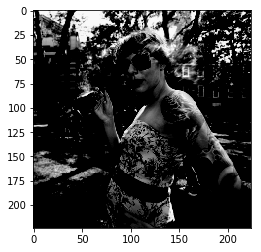

In [17]:
plt.imshow(imgs_for_input[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


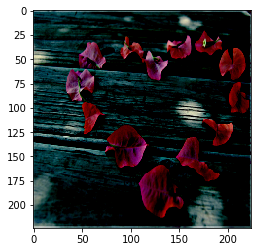

In [17]:
plt.imshow(imgs_for_output[1]) # index nya ubah untuk ganti image